# Bahrain 2024

In [1]:
# pip install fastf1 (without showing the process)
import subprocess

subprocess.run(['pip', 'install', 'fastf1'],
               stdout=subprocess.DEVNULL,
               stderr=subprocess.DEVNULL)


CompletedProcess(args=['pip', 'install', 'fastf1'], returncode=0)

# FastF1

In [1]:
# FastF1 Library: Provides telemetry, lap times, tire wear, and pit stop data.
import fastf1
import pandas as pd
import logging
import warnings

# Disable logging from FastF1
logging.getLogger("fastf1").setLevel(logging.CRITICAL)

# Suppress all Python warnings
warnings.filterwarnings("ignore")

# Optional: Enable caching to speed up repeated runs
# fastf1.Cache.enable_cache('cache')

# Load Bahrain GP Race (2024)
session = fastf1.get_session(2024, 'Bahrain', 'R')
session.load()

# Extract laps data as a DataFrame
bahrain2024 = session.laps


c:\Users\prana\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\prana\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\Users\prana\Anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
bahrain2024.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:01:37.510000,VER,1,0 days 00:01:37.284000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:41.266000,...,False,Red Bull Racing,0 days 00:59:59.911000,2024-03-02 15:03:42.342,12,1.0,False,,False,False
1,0 days 01:03:13.806000,VER,1,0 days 00:01:36.296000,2.0,1.0,NaT,NaT,0 days 00:00:30.916000,0 days 00:00:41.661000,...,False,Red Bull Racing,0 days 01:01:37.510000,2024-03-02 15:05:19.941,1,1.0,False,,False,True
2,0 days 01:04:50.559000,VER,1,0 days 00:01:36.753000,3.0,1.0,NaT,NaT,0 days 00:00:30.999000,0 days 00:00:41.966000,...,False,Red Bull Racing,0 days 01:03:13.806000,2024-03-02 15:06:56.237,1,1.0,False,,False,True
3,0 days 01:06:27.206000,VER,1,0 days 00:01:36.647000,4.0,1.0,NaT,NaT,0 days 00:00:30.931000,0 days 00:00:41.892000,...,False,Red Bull Racing,0 days 01:04:50.559000,2024-03-02 15:08:32.990,1,1.0,False,,False,True
4,0 days 01:08:04.379000,VER,1,0 days 00:01:37.173000,5.0,1.0,NaT,NaT,0 days 00:00:31.255000,0 days 00:00:42.056000,...,False,Red Bull Racing,0 days 01:06:27.206000,2024-03-02 15:10:09.637,1,1.0,False,,False,True


In [3]:
bahrain2024.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

## 🏁 Pit Stop Strategy Feature Mapping

| # | Strategy Feature                 | Mapped Column(s) in `bahrain2024`                                     | Notes                                                                 |
|---|----------------------------------|------------------------------------------------------------------------|-----------------------------------------------------------------------|
| 1 | **Pace of tyre/car**             | `LapTime`, `Sector1Time`, `Sector2Time`, `Sector3Time`, `Position`    | Use lap and sector times to estimate raw pace.                        |
| 2 | **Warmup on the tyre**           | `TyreLife`, `FreshTyre`, `Compound`                                   | Analyze lap time trends on new tyre.                                  |
| 3 | **Tyre degradation**             | `LapTime`, `TyreLife`, `Compound`, `Stint`                            | Use pace vs TyreLife to infer degradation.                            |
| 4 | **Performance life (tyre)**      | `TyreLife`, `Compound`, `LapNumber`                                   | Model how long each compound remains quick.                           |
| 5 | **Wear life**                    | `TyreLife`, `Compound`, `Stint`                                       | Related to performance life but more on usage cap.                    |
| 6 | **Track temperature / tyre temperature** | ❌ *Not available directly*                                   | Consider estimating or flag as missing for now.                       |
| 7 | **Time to complete pitstop**     | `PitOutTime`, `PitInTime`                                             | Can calculate pitstop duration.                                       |


In [4]:
import pandas as pd
import numpy as np

# Work on a copy of the original DataFrame
df = bahrain2024.copy()

# ✅ 1. Convert LapTime to seconds for pace analysis
df['LapTime_sec'] = pd.to_timedelta(df['LapTime']).dt.total_seconds()

# ✅ 2. Warm-up: retain TyreLife, FreshTyre, and Compound
# Already in df, no changes needed

# ✅ 3. Tyre degradation: lap-to-lap delta in LapTime within stint
df['LapTime_Delta'] = df.groupby(['Driver', 'Stint'])['LapTime_sec'].diff()
df['TyreLife_Delta'] = df.groupby(['Driver', 'Stint'])['TyreLife'].diff()
df['DegradationPerLap'] = df['LapTime_Delta'] / df['TyreLife_Delta']
df['DegradationPerLap'].replace([np.inf, -np.inf], np.nan, inplace=True)

# ✅ 4. Performance life: TyreLife + Compound + LapNumber used directly

# ✅ 5. Wear life: max TyreLife per stint
df['StintMaxTyreLife'] = df.groupby(['Driver', 'Stint'])['TyreLife'].transform('max')

# ✅ 6. Track/Tyre Temperature: not available, add placeholder
df['TrackTemp'] = np.nan
df['TyreTemp'] = np.nan

# ✅ 7. Pitstop Duration
df['PitInTime'] = pd.to_datetime(df['PitInTime'], errors='coerce')
df['PitOutTime'] = pd.to_datetime(df['PitOutTime'], errors='coerce')
df['PitStopDuration'] = (df['PitOutTime'] - df['PitInTime']).dt.total_seconds()

# ✅ Label TireChange laps
df['TireChange'] = np.where(df['PitStopDuration'].notnull(), 1, 0)


In [5]:
df.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,IsAccurate,LapTime_sec,LapTime_Delta,TyreLife_Delta,DegradationPerLap,StintMaxTyreLife,TrackTemp,TyreTemp,PitStopDuration,TireChange
0,0 days 01:01:37.510000,VER,1,0 days 00:01:37.284000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:41.266000,...,False,97.284,NaN,NaN,NaN,20.0,NaN,NaN,NaN,0
1,0 days 01:03:13.806000,VER,1,0 days 00:01:36.296000,2.0,1.0,NaT,NaT,0 days 00:00:30.916000,0 days 00:00:41.661000,...,True,96.296,-0.988,1.0,-0.988,20.0,NaN,NaN,NaN,0
2,0 days 01:04:50.559000,VER,1,0 days 00:01:36.753000,3.0,1.0,NaT,NaT,0 days 00:00:30.999000,0 days 00:00:41.966000,...,True,96.753,0.457,1.0,0.457,20.0,NaN,NaN,NaN,0
3,0 days 01:06:27.206000,VER,1,0 days 00:01:36.647000,4.0,1.0,NaT,NaT,0 days 00:00:30.931000,0 days 00:00:41.892000,...,True,96.647,-0.106,1.0,-0.106,20.0,NaN,NaN,NaN,0
4,0 days 01:08:04.379000,VER,1,0 days 00:01:37.173000,5.0,1.0,NaT,NaT,0 days 00:00:31.255000,0 days 00:00:42.056000,...,True,97.173,0.526,1.0,0.526,20.0,NaN,NaN,NaN,0


In [15]:
def plot_degradation_by_compound(df, driver_name):
    # F1 compound color map
    compound_colors = {
        'SOFT': '#FF3333',         # Red
        'MEDIUM': '#FFD700',       # Yellow
        'HARD': '#A9A9A9',         # Grey
        'INTERMEDIATE': '#32CD32', # Green
        'WET': '#1E90FF'           # Blue
    }

    # Filter and clean
    driver_df = df[df['Driver'] == driver_name].copy()
    driver_df = driver_df[driver_df['LapTime_sec'].notnull()]

    plt.figure(figsize=(12, 6))

    # Plot each stint-compound combo separately
    for (stint, compound), stint_df in driver_df.groupby(['Stint', 'Compound']):
        plt.plot(
            stint_df['LapNumber'],
            stint_df['LapTime_sec'],
            label=f'{compound} - Stint {stint}',
            color=compound_colors.get(compound.upper(), 'black'),
            marker='o',
            linewidth=2
        )
    
    plt.title(f'Tyre Degradation by Compound – {driver_name}')
    plt.xlabel('Lap Number')
    plt.ylabel('Lap Time (s)')
    plt.legend(title='Compound + Stint')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


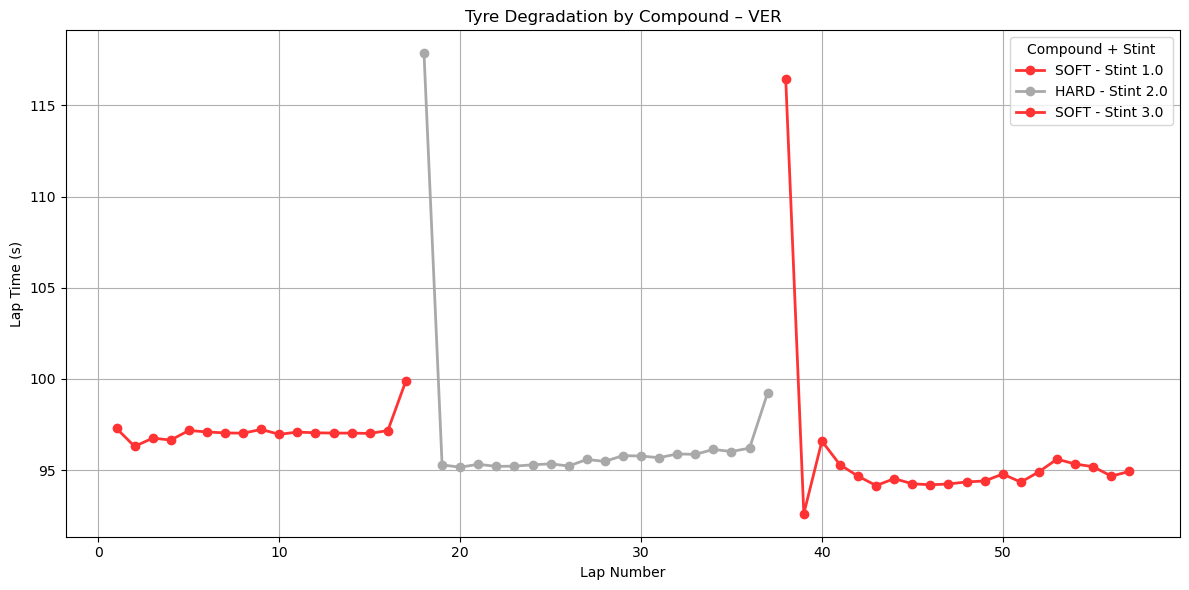

In [16]:
plot_degradation_by_compound(df, driver_name='VER')  # or any other driver like 'HAM', 'LEC', etc.


In [18]:
# Final selected columns for modeling
model_columns = [
    'Driver', 'LapNumber', 'Stint', 'TyreLife', 'FreshTyre', 'Compound',
    'LapTime_sec', 'LapTime_Delta', 'DegradationPerLap', 'StintMaxTyreLife',
    'PitStopDuration', 'TireChange'
]

df_model = df[model_columns].copy()


In [19]:
df_model

,Driver,LapNumber,Stint,TyreLife,FreshTyre,Compound,LapTime_sec,LapTime_Delta,DegradationPerLap,StintMaxTyreLife,PitStopDuration,TireChange
0,VER,1.0,1.0,4.0,False,SOFT,97.284,NaN,NaN,20.0,NaN,0
1,VER,2.0,1.0,5.0,False,SOFT,96.296,-0.988,-0.988,20.0,NaN,0
2,VER,3.0,1.0,6.0,False,SOFT,96.753,0.457,0.457,20.0,NaN,0
3,VER,4.0,1.0,7.0,False,SOFT,96.647,-0.106,-0.106,20.0,NaN,0
4,VER,5.0,1.0,8.0,False,SOFT,97.173,0.526,0.526,20.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1124,SAR,51.0,4.0,11.0,True,SOFT,95.972,0.312,0.312,15.0,NaN,0
1125,SAR,52.0,4.0,12.0,True,SOFT,95.987,0.015,0.015,15.0,NaN,0
1126,SAR,53.0,4.0,13.0,True,SOFT,96.088,0.101,0.101,15.0,NaN,0
1127,SAR,54.0,4.0,14.0,True,SOFT,99.614,3.526,3.526,15.0,NaN,0


In [21]:
# Check for missing data
df_model.isnull().sum()


Driver                  0
LapNumber               0
Stint                   0
TyreLife                0
FreshTyre               0
Compound                0
LapTime_sec             2
LapTime_Delta          65
DegradationPerLap      65
StintMaxTyreLife        0
PitStopDuration      1129
TireChange              0
dtype: int64

# Ergast

In [ ]:
import requests
import pandas as pd

# Fetch Monaco 2023 race results
url = "http://ergast.com/api/f1/2023/6/results.json"
response = requests.get(url)
data = response.json()

# Confirm it's Monaco GP
race_info = data['MRData']['RaceTable']['Races'][0]
print(f"Race: {race_info['raceName']} on {race_info['date']}")

# Extract and normalize results
results = race_info['Results']
monaco2023results= pd.json_normalize(results)

# Preview
print(monaco2023results.head())


try to create model first with the existing features, so only feature cleaning and no new features creations.